<a href="https://colab.research.google.com/github/crispy0024/Codex_Puzzle/blob/main/Masking_puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless scikit-learn pandas

In [ ]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2                              # OpenCV for image processing :contentReference[oaicite:5]{index=5}
import numpy as np                      # NumPy for numerical operations :contentReference[oaicite:6]{index=6}
import os                               # os for filesystem traversal :contentReference[oaicite:7]{index=7}
import matplotlib.pyplot as plt         # Matplotlib for visualization :contentReference[oaicite:8]{index=8}

from tqdm.notebook import tqdm  # Use tqdm.notebook for Colab/Jupyter


In [ ]:
image_folder = "/content/drive/MyDrive/Puzzle/puzzle_individual_pieces_v1"

In [ ]:
def remove_background(piece_img, iter_count=5, rect_margin=1):
    """
    Remove background from a puzzle piece image using GrabCut.

    Args:
        piece_img (ndarray): BGR image of a single puzzle piece.
        iter_count (int): Number of GrabCut iterations (higher = potentially better segmentation) :contentReference[oaicite:14]{index=14}.
        rect_margin (int): Pixel margin inside the image border to initialize the rectangle.

    Returns:
        mask (ndarray): Binary mask (uint8) where foreground pixels = 1, background pixels = 0.
        segmented (ndarray): Original image where background pixels are zeroed out.
    """
    # Initialize mask required by GrabCut with all pixels marked “probable background” :contentReference[oaicite:15]{index=15}
    mask = np.zeros(piece_img.shape[:2], dtype=np.uint8)  # 0 = GC_BGD (obvious background) :contentReference[oaicite:16]{index=16}

    # Models used internally by GrabCut (we can ignore their contents after segmentation) :contentReference[oaicite:17]{index=17}
    bgd_model = np.zeros((1, 65), dtype=np.float64)
    fgd_model = np.zeros((1, 65), dtype=np.float64)

    # Compute rectangle for GrabCut initialization: (x, y, width, height) inside the image borders :contentReference[oaicite:18]{index=18}
    h, w = piece_img.shape[:2]
    rect = (rect_margin, rect_margin, w - 2*rect_margin, h - 2*rect_margin)

    # Apply GrabCut: mode = GC_INIT_WITH_RECT to initialize from a rectangle :contentReference[oaicite:19]{index=19}
    cv2.grabCut(piece_img, mask, rect, bgd_model, fgd_model, iter_count, cv2.GC_INIT_WITH_RECT)

    # Convert mask to binary: pixels marked as probable/definite foreground become 1, others become 0 :contentReference[oaicite:20]{index=20}
    mask2 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')

    # Create segmented image: original pixel × mask (expand mask dims for BGR) :contentReference[oaicite:21]{index=21}
    segmented = piece_img * mask2[:, :, np.newaxis]

    return mask2, segmented


In [ ]:
valid_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")        # Supported image types :contentReference[oaicite:23]{index=23}
all_files = [f for f in os.listdir(image_folder) if f.lower().endswith(valid_ext)]
print(f"Found {len(all_files)} images.")                     # Display count :contentReference[oaicite:24]{index=24}


Found 2000 images.


In [ ]:
# Define output folders (create if they don’t exist)
mask_folder = os.path.join(image_folder, "masks")
seg_folder = os.path.join(image_folder, "segmented")
os.makedirs(mask_folder, exist_ok=True)                       # Create masks/ directory :contentReference[oaicite:33]{index=33}
os.makedirs(seg_folder, exist_ok=True)                         # Create segmented/ directory :contentReference[oaicite:34]{index=34}


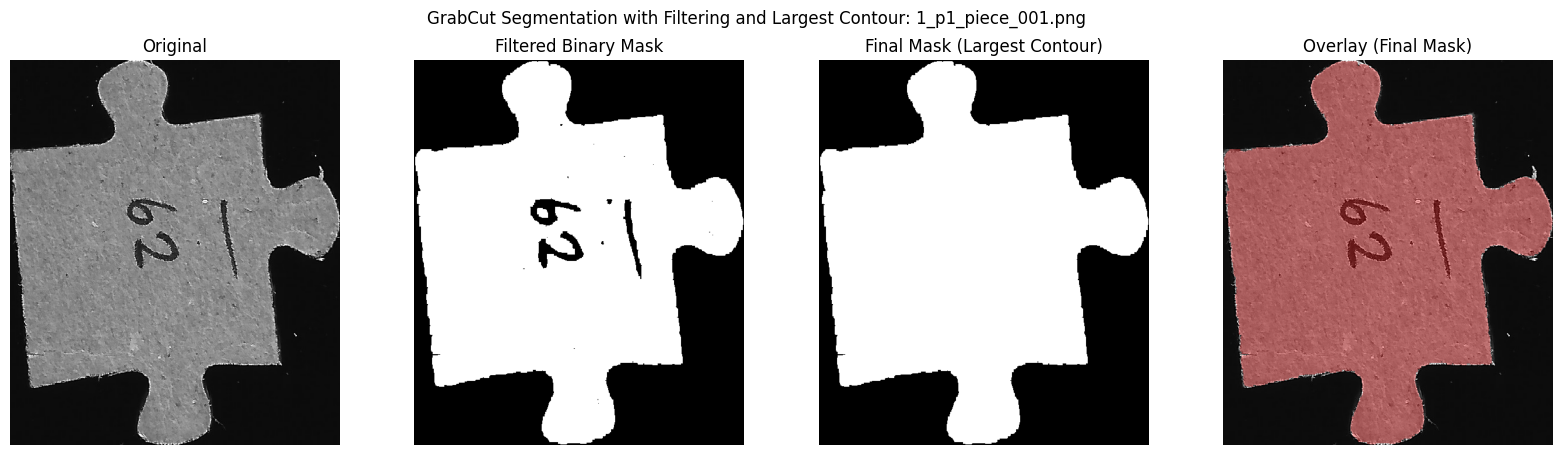

In [ ]:
# Apply GrabCut segmentation

# Select a sample image for demonstration purposes
if all_files:
    sample_fname = all_files[0]
    sample_path = os.path.join(image_folder, sample_fname)
    orig = cv2.imread(sample_path)
    if orig is not None:
        orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib display
    else:
        print(f"Warning: Could not read sample image {sample_fname}. Skipping visualization.")
        orig = None # Ensure orig is None if image reading failed
else:
    print("No images found in the specified folder. Skipping visualization.")
    orig = None # Ensure orig is None if no files are found

# Only proceed with visualization if a sample image was loaded successfully
if orig is not None:
    mask, segmented = remove_background(orig)

    # --- Morphological Filtering to remove noise ---
    kernel = np.ones((5, 5), np.uint8)

    mask_eroded = cv2.erode(mask, kernel, iterations=2)
    mask_filtered = cv2.dilate(mask_eroded, kernel, iterations=2)
    mask_eroded2 = cv2.erode(mask_filtered, kernel, iterations=1)
    mask_filtered2 = cv2.dilate(mask_eroded2, kernel, iterations=1)
    # --- End of Morphological Filtering ---

    # --- Find and fill the largest contour ---
    # Find contours in the filtered mask
    contours, _ = cv2.findContours(mask_filtered2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask to draw the largest contour on
    mask_largest_contour = np.zeros_like(mask_filtered)

    if contours: # Check if any contours were found
        # Find the largest contour based on area
        largest_contour = max(contours, key=cv2.contourArea)

        # Draw the largest contour filled on the new blank mask
        cv2.drawContours(mask_largest_contour, [largest_contour], -1, 1, cv2.FILLED)

    # Now mask_largest_contour is your final, single-object mask
    mask_final = mask_largest_contour
    # --- End of finding and filling largest contour ---


    # Prepare overlay for visualization: highlight mask area in semi-transparent red
    overlay = orig_rgb.copy()
    # Use the final mask for visualization and segmentation
    # Need to ensure overlay and mask_final have compatible shapes for the boolean indexing
    # The mask needs to be expanded to 3 dimensions to match the RGB image
    overlay[mask_final == 1] = [255, 0, 0] # This assumes mask_final is broadcastable or 3D

    # A safer way to apply the overlay based on the mask
    # Create a red overlay layer
    red_overlay = np.zeros_like(orig_rgb, dtype=np.uint8)
    red_overlay[:] = [255, 0, 0] # Set all pixels to red

    # Apply the red overlay only where the final mask is 1
    blended = cv2.addWeighted(orig_rgb, 0.7, red_overlay, 0.3, 0)
    # This line was problematic: overlay[mask_final == 1] = [255, 0, 0]

    # To apply the blend correctly based on the mask, we can use the mask to select pixels
    # Or, we can apply the blend over the entire image and rely on the segmentation later
    # The previous approach using addWeighted is generally for blending two full images.
    # If the goal is to ONLY highlight the masked area, a different approach is needed.

    # Let's rethink the overlay for clarity.
    # Create a red colored image
    red_color_img = np.full(orig_rgb.shape, [255, 0, 0], dtype=np.uint8)

    # Create an overlay by combining the original image and the red color image, weighted by the mask
    # Where mask_final is 1 (foreground), use the original image (or a blend with red)
    # Where mask_final is 0 (background), use the original image
    # A common way is to create a blended image that is original in background and blended in foreground
    blended_highlight = orig_rgb.copy()
    # Apply a blend only to the foreground area as defined by the mask
    alpha = 0.3 # Transparency of the red overlay
    # Create a mask where the foreground pixels are alpha and background pixels are 1-alpha for blending
    # This isn't quite right for just highlighting the foreground.

    # A simpler and clearer approach to highlight the foreground area:
    # Create a semi-transparent red layer
    red_layer = np.full(orig_rgb.shape, [255, 0, 0], dtype=np.uint8)
    # Use the final mask to select where the red layer should be applied
    # The mask needs to be 3 channels to broadcast correctly for element-wise operations
    mask_final_3chan = np.stack([mask_final]*3, axis=-1)

    # Blend the original image with the red layer based on the mask
    # Result = (1 - mask_final) * original + mask_final * (blended_red_original)
    # This is still overly complex for just highlighting.

    # Let's go back to a simpler overlay for visualization:
    # Create a copy of the original image
    blended_viz = orig_rgb.copy()
    # Apply a semi-transparent red tint to the pixels where the mask is 1
    # This can be done by directly calculating the weighted sum for the foreground pixels
    alpha = 0.3
    blended_viz[mask_final == 1] = (1 - alpha) * blended_viz[mask_final == 1].astype(np.float32) + alpha * np.array([255, 0, 0], dtype=np.float32)
    blended_viz = blended_viz.astype(np.uint8)

    # Create the segmented image using the final mask
    segmented_final = orig * mask_final[:, :, np.newaxis]

    # Display results
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(orig_rgb);          axs[0].set_title("Original");          axs[0].axis('off')
    axs[1].imshow(mask_filtered, cmap='gray'); axs[1].set_title("Filtered Binary Mask"); axs[1].axis('off') # Display filtered mask
    axs[2].imshow(mask_final, cmap='gray'); axs[2].set_title("Final Mask (Largest Contour)"); axs[2].axis('off') # New plot for final mask
    axs[3].imshow(blended_viz);           axs[3].set_title("Overlay (Final Mask)"); axs[3].axis('off') # Updated title
    plt.suptitle(f"GrabCut Segmentation with Filtering and Largest Contour: {sample_fname}") # Updated main title
    plt.show()

In [ ]:
# Apply GrabCut segmentation to all files
# Wrap the all_files list with tqdm for a progress bar
for fname in tqdm(all_files, desc="Processing images"):
    path = os.path.join(image_folder, fname)
    img = cv2.imread(path)                                     # Read BGR image
    if img is None:
        continue                                                # Skip unreadable files

    # Apply GrabCut
    mask, segmented_img = remove_background(img)                # Segment the piece

    # Save binary mask (0/1) scaled to 0/255 for PNG
    mask_to_save = (mask * 255).astype(np.uint8)                # Convert mask to 0–255
    mask_out_path = os.path.join(mask_folder, f"{os.path.splitext(fname)[0]}_mask.png")
    cv2.imwrite(mask_out_path, mask_to_save)                    # Write mask PNG

    # Save segmented image
    seg_out_path = os.path.join(seg_folder, f"{os.path.splitext(fname)[0]}_segmented.png")
    cv2.imwrite(seg_out_path, segmented_img)                    # Write segmented piece PNG

Processing images:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# 6.1 Quality Checks: Identify masks with low solidity or abnormal area
import pandas as pd
from glob import glob

# Load all mask paths
mask_paths = glob(os.path.join(mask_folder, "*_mask.png"))

# Containers for statistics
stats = []

for mpath in mask_paths:
    mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
    # Find largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        continue
    c = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(c)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull) if hull is not None else 0
    solidity = float(area)/hull_area if hull_area != 0 else 0
    x, y, w, h = cv2.boundingRect(c)
    bbox_area = w*h
    # Check if contour touches image border
    h_img, w_img = mask.shape
    touches_border = (
        (x <= 0) or (y <= 0) or (x + w >= w_img - 1) or (y + h >= h_img - 1)
    )
    stats.append({
        'mask_path': mpath,
        'area': area,
        'hull_area': hull_area,
        'solidity': solidity,
        'bbox_area': bbox_area,
        'touches_border': touches_border
    })

df_stats = pd.DataFrame(stats)

# Compute median area across all masks
median_area = df_stats['area'].median()

# Flag masks with low solidity (< 0.5) or area < 50% of median
problematic = df_stats[
    (df_stats['solidity'] < 0.5) |
    (df_stats['area'] < 0.5 * median_area) |
    (df_stats['touches_border'] == True)
].copy()

print(f"Median mask area: {median_area:.1f}")
if not problematic.empty:
    print("Problematic masks detected:")
    display(problematic)
else:
    print("All masks passed basic quality checks.")


Median mask area: 180060.8
Problematic masks detected:


,mask_path,area,hull_area,solidity,bbox_area,touches_border
0,/content/drive/MyDrive/Puzzle/puzzle_individua...,153775.5,212463.0,0.723775,267624,True
1,/content/drive/MyDrive/Puzzle/puzzle_individua...,163339.0,214635.0,0.761008,257526,True
2,/content/drive/MyDrive/Puzzle/puzzle_individua...,172798.0,237641.5,0.727137,305728,True
3,/content/drive/MyDrive/Puzzle/puzzle_individua...,165954.0,223940.0,0.741065,233285,True
4,/content/drive/MyDrive/Puzzle/puzzle_individua...,169608.0,228214.0,0.743197,256360,True
...,...,...,...,...,...,...
1995,/content/drive/MyDrive/Puzzle/puzzle_individua...,195998.0,257574.5,0.760937,328635,True
1996,/content/drive/MyDrive/Puzzle/puzzle_individua...,192518.0,272891.5,0.705475,319680,True
1997,/content/drive/MyDrive/Puzzle/puzzle_individua...,175759.5,228179.5,0.770269,285969,True
1998,/content/drive/MyDrive/Puzzle/puzzle_individua...,178624.5,242628.0,0.736207,291924,True


In [ ]:
# 6.2.1 Feature Extraction (re-using extract_features from Section 4.2)
# We’ll loop over each segmented mask, extract features, and build a DataFrame.

feature_records = []

for idx, row in df_stats.iterrows():
    mpath = row['mask_path']
    mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE) // 255  # Convert to binary {0,1}
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        continue
    c = max(contours, key=cv2.contourArea)
    # Compute bounding box and Hu moments
    x, y, w, h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/hull_area if hull_area != 0 else 0
    aspect_ratio = float(w)/h if h != 0 else 0
    hu = cv2.HuMoments(cv2.moments(c)).flatten()
    feature_records.append({
        'mask_path': mpath,
        'area': area,
        'perimeter': perimeter,
        'bbox_x': x,
        'bbox_y': y,
        'bbox_w': w,
        'bbox_h': h,
        'aspect_ratio': aspect_ratio,
        'solidity': solidity,
        'hu_1': float(hu[0]),
        'hu_2': float(hu[1]),
        'hu_3': float(hu[2]),
        'hu_4': float(hu[3]),
        'hu_5': float(hu[4]),
        'hu_6': float(hu[5]),
        'hu_7': float(hu[6]),
    })

df_shape = pd.DataFrame(feature_records)
print(f"Extracted shape features for {len(df_shape)} pieces.")
df_shape.head()


Extracted shape features for 2000 pieces.


,mask_path,area,perimeter,bbox_x,bbox_y,bbox_w,bbox_h,aspect_ratio,solidity,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,hu_7
0,/content/drive/MyDrive/Puzzle/puzzle_individua...,153775.5,2931.696730,1,1,531,504,1.053571,0.723775,0.202508,0.000138,0.000683,3.753798e-05,5.660843e-09,8.695247e-08,2.018986e-09
1,/content/drive/MyDrive/Puzzle/puzzle_individua...,163339.0,3018.424651,1,1,502,513,0.978558,0.761008,0.199668,0.000526,0.000502,4.783978e-07,5.508860e-12,6.535665e-09,-4.965956e-12
2,/content/drive/MyDrive/Puzzle/puzzle_individua...,172798.0,3159.797235,1,1,562,544,1.033088,0.727137,0.202090,0.000115,0.000866,2.175718e-05,-3.257709e-12,-2.326733e-07,2.986052e-09
3,/content/drive/MyDrive/Puzzle/puzzle_individua...,165954.0,3503.267358,1,1,485,481,1.008316,0.741065,0.222132,0.000032,0.000040,3.044996e-06,3.047465e-11,1.628991e-08,-1.368616e-11
4,/content/drive/MyDrive/Puzzle/puzzle_individua...,169608.0,3315.586119,1,2,520,493,1.054767,0.743197,0.217492,0.000722,0.000028,2.658311e-06,2.305852e-11,6.807334e-08,1.278694e-12


In [ ]:
def detect_piece_corners(mask, max_corners=20, quality_level=0.01, min_distance=10):
    """
    Detect corner points on the puzzle piece boundary using Shi-Tomasi (GoodFeaturesToTrack).
    Args:
        mask (ndarray): Binary mask of the piece {0,1}.
        max_corners (int): Max number of corners to detect.
        quality_level (float): Minimum accepted quality level for corners.
        min_distance (int): Minimum distance between detected corners.
    Returns:
        corners (ndarray): N×2 array of corner coordinates (x, y).
    """
    # Find edges of the mask
    edges = cv2.Canny((mask * 255).astype(np.uint8), 50, 150)  # Edge map {0,255} :contentReference[oaicite:16]{index=16}

    # Use goodFeaturesToTrack on edge map to find strong corner points
    corners = cv2.goodFeaturesToTrack(
        edges,
        maxCorners=max_corners,
        qualityLevel=quality_level,
        minDistance=min_distance
    )
    if corners is None:
        return np.empty((0, 2), dtype=np.int32)

    corners = corners.astype(np.int32).reshape(-1, 2)  # (N,2) array of (x,y) :contentReference[oaicite:17]{index=17}
    return corners

# Example: detect corners on a sample mask
test_mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE) // 255
corners = detect_piece_corners(test_mask)
print(f"Detected corners (x,y): {corners}")


Detected corners (x,y): [[491 235]
 [173 129]
 [522 469]
 [121 126]
 [447 485]
 [106 373]
 [479 231]
 [ 43 376]
 [244 394]
 [239 467]
 [516 348]
 [ 58 371]
 [213  94]
 [472 482]
 [232 453]
 [380 499]
 [ 24 264]
 [526 353]
 [120 469]
 [224 427]]


In [ ]:
from sklearn.cluster import KMeans

def select_four_corners(corner_pts):
    """
    Given N corner candidates, cluster them into 4 groups and pick one representative per cluster.
    Args:
        corner_pts (ndarray): Nx2 array of (x,y) points.
    Returns:
        final_corners (ndarray): 4x2 array of cluster centers (approx. piece corners).
    """
    if len(corner_pts) < 4:
        # Not enough candidates → return what we have (may need manual fix)
        return corner_pts

    kmeans = KMeans(n_clusters=4, random_state=42).fit(corner_pts)
    # The cluster centers are likely near the true corners
    return np.int32(kmeans.cluster_centers_)

# Example usage:
if corners.shape[0] >= 4:
    four_pts = select_four_corners(corners)
    print("Clustered into 4 corners:", four_pts)


Clustered into 4 corners: [[ 57 346]
 [493 371]
 [169 116]
 [239 451]]


In [ ]:
# Example usage on a single piece:
# Get the path to the original image corresponding to the mask_paths[0]
# Assumes mask_paths[0] is like '/content/drive/MyDrive/Puzzle/.../masks/filename_mask.png'
# We need the path to the original image file, like '/content/drive/MyDrive/Puzzle/.../filename.png'
# Extract the original filename from the mask path
mask_filename = os.path.basename(mask_paths[0]) # e.g., '1_p1_piece_001_mask.png'
# Remove '_mask.png' and get original extension
original_fname_base = mask_filename.replace('_mask.png', '')
# Find the corresponding original file in the image_folder
original_fname = [f for f in all_files if f.startswith(original_fname_base)][0] # Find the first match
original_path = os.path.join(image_folder, original_fname)


orig_piece = cv2.imread(original_path)
mask_piece = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE) // 255

# --- Add a check here to ensure dimensions match ---
if orig_piece.shape[:2] != mask_piece.shape:
    print(f"Dimension mismatch: Original image shape {orig_piece.shape[:2]}, Mask shape {mask_piece.shape}")
    # Handle this case - perhaps skip or try to resize the mask/image if appropriate
    # For now, we'll assume the rest of the code might fail if mismatch occurs.
    # A better approach might be to ensure the segmentation and saving process
    # maintains consistent dimensions between original image and mask.
# ----------------------------------------------------


# Assume corners were computed already (e.g., via detect_piece_corners + cluster)
# Use the potentially dimension-corrected mask for corner detection
corners_sample = select_four_corners(
    detect_piece_corners(mask_piece)
)

# Proceed only if 4 corners were found
if corners_sample.shape[0] == 4:
    # Use the loaded original piece and the corresponding mask for feature extraction
    edge_feats = extract_edge_descriptors(orig_piece, mask_piece, corners_sample, edge_width=15)
    print(f"Extracted descriptors for {len(edge_feats)} edges.")
else:
    print(f"Could not detect 4 corners for the sample piece. Detected {corners_sample.shape[0]}.")

Extracted descriptors for 4 edges.


In [ ]:
from sklearn.neighbors import NearestNeighbors

# 6.4.1 Build a table of all edges’ histograms
all_edge_hists = []
edge_identifiers = []  # (piece_index, edge_index)
for idx, fname in enumerate(all_files):
    # Load piece image and corresponding mask and corners
    orig_img = cv2.imread(os.path.join(image_folder, fname))
    mask_img = cv2.imread(os.path.join(mask_folder, f"{os.path.splitext(fname)[0]}_mask.png"), cv2.IMREAD_GRAYSCALE) // 255
    corners = select_four_corners(detect_piece_corners(mask_img))
    edge_feats = extract_edge_descriptors(orig_img, mask_img, corners, edge_width=15)

    # Append each edge’s histogram to the list
    for ef in edge_feats:
        if ef['color_hist'] is not None:
            all_edge_hists.append(ef['color_hist'])
            edge_identifiers.append((idx, ef['edge_index']))

# Convert to NumPy array
X = np.stack(all_edge_hists)  # Shape: (num_total_edges, 512)

# 6.4.2 Fit a NearestNeighbors index
nn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(X)

# 6.4.3 For each edge, find its top‐k neighbors (possible matches)
distances, indices = nn.kneighbors(X)

# Example: print the top 3 matches for the first edge
print(f"Edge {edge_identifiers[0]} top‐3 matches:")
for j in range(1, 4):  # skip itself at position 0
    match_idx = indices[0, j]
    piece_idx, edge_idx = edge_identifiers[match_idx]
    dist = distances[0, j]
    print(f" → Piece {piece_idx} edge {edge_idx} (distance = {dist:.4f})")


Edge (0, 0) top‐3 matches:
 → Piece 212 edge 0 (distance = 0.0027)
 → Piece 1304 edge 2 (distance = 0.0081)
 → Piece 206 edge 2 (distance = 0.0111)


In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm                    # Progress bars
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import logging

# Optional: configure logging to print INFO-level messages
logging.basicConfig(level=logging.INFO, format="%(asctime)s – %(levelname)s – %(message)s")


In [ ]:
def is_edge_straight(mask, corner1, corner2, tolerance=0.98, sample_points=50):
    """
    Checks if the edge segment between two corner points on a mask boundary is straight.
    It samples points along the line segment connecting the corners and checks
    if a large percentage of these points fall within the mask boundary.

    Args:
        mask (ndarray): Binary mask of the piece {0,1}.
        corner1 (tuple): (x, y) coordinates of the first corner.
        corner2 (tuple): (x, y) coordinates of the second corner.
        tolerance (float): Minimum percentage of sample points that must be within the mask.
        sample_points (int): Number of points to sample along the line segment.

    Returns:
        bool: True if the edge is considered straight, False otherwise.
    """
    # Get coordinates
    x1, y1 = corner1
    x2, y2 = corner2

    # Generate points along the line segment using linear interpolation
    # Ensure points are within mask dimensions
    h, w = mask.shape
    x_coords = np.linspace(x1, x2, sample_points).astype(int)
    y_coords = np.linspace(y1, y2, sample_points).astype(int)

    # Filter points to be within mask boundaries
    valid_indices = (x_coords >= 0) & (x_coords < w) & (y_coords >= 0) & (y_coords < h)
    x_coords = x_coords[valid_indices]
    y_coords = y_coords[valid_indices]

    if len(x_coords) == 0:
        # If no points are within bounds, can't determine straightness reliably.
        # Might indicate corners are too close or outside the mask.
        # For simplicity, let's say it's not straight in this edge case.
        return False

    # Check if sampled points are within the mask boundary (where mask is 1)
    # We need to check if the points are close to the boundary, not just inside.
    # A simple check is if the point itself is on the mask boundary (where mask == 1).
    # A more robust check might involve looking at a small neighborhood around the point.

    # Let's use a simplified check: are the sampled points "on" the piece mask?
    # This assumes the line segment should roughly follow the mask boundary for a straight edge.
    points_on_mask = mask[y_coords, x_coords] # Note: mask indexing is row (y), column (x)

    # Calculate the percentage of points that are within the mask
    percentage_on_mask = np.sum(points_on_mask) / sample_points # Use original sample_points for percentage calculation

    # Check if the percentage meets the tolerance
    return percentage_on_mask >= tolerance

In [ ]:
def classify_piece_type(mask, corners):
    """
    Simple heuristic:
        - Count how many of the 4 sides (corner[i]→corner[i+1]) are “straight.”
        - If 2 → corner piece, if 1 → edge piece, else → middle piece.
    """
    straight_count = 0
    for i in range(4):
        A = tuple(corners[i])
        B = tuple(corners[(i+1) % 4])
        # Re‐use the function from Section 6.2.2 for “is this side straight?”
        if is_edge_straight(mask, A, B, tolerance=0.98):
            straight_count += 1

    if straight_count == 2:
        return "corner"
    elif straight_count == 1:
        return "edge"
    else:
        return "middle"


In [ ]:
# 1) Set your folders (modify if your Drive path is different)
image_folder = "/content/drive/MyDrive/Puzzle/puzzle_individual_pieces_v1/"
mask_folder  = "/content/drive/MyDrive/Puzzle/puzzle_individual_pieces_v1/masks/"

# 2) List only the “piece” filenames (skip masks/subfolders)
valid_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
all_pieces = [f for f in os.listdir(image_folder) if f.lower().endswith(valid_ext)]
all_pieces.sort()  # optional, so they run in a consistent order

logging.info(f"Found {len(all_pieces)} puzzle‐piece images.")

# 3) Pre-allocate lists for all-edge data
edge_hist_list    = []  # list of 512-D color histos
edge_sift_list    = []  # list of (num_kp×128) SIFT descriptors (or None)
edge_id_list      = []  # list of tuples (piece_idx, edge_idx)
piece_corner_map  = {}  # map piece_idx → 4 corners (so we don’t recompute)
piece_type_map    = {}  # map piece_idx → "corner"/"edge"/"middle"
edge_mask_map     = {}  # optional: store the polygon‐mask for each edge if you want to visualize later


In [ ]:
# If you want to save intermediate DataFrames:
records = []

logging.info("Starting Step 6.4: Extracting features from every piece’s edges…")

for piece_idx, fname in enumerate(tqdm(all_pieces, desc="Pieces")):
    img_path = os.path.join(image_folder, fname)
    orig     = cv2.imread(img_path)
    if orig is None:
        logging.warning(f"Could not read {fname}, skipping.")
        continue

    # 1) Load the corresponding mask
    mask_path = os.path.join(mask_folder, f"{os.path.splitext(fname)[0]}_mask.png")
    mask      = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        logging.warning(f"No mask found for {fname}, skipping.")
        continue
    mask_binary = (mask // 255).astype(np.uint8)

    # 2) Find piece corners (cache them so we don’t run Shi‐Tomasi 4× for each edge)
    corners = detect_piece_corners(mask_binary)
    if corners is None or len(corners) < 4:
        logging.warning(f"Not enough corner candidates for {fname} (found {len(corners)}), skipping.")
        continue
    # Reduce to exactly 4 by clustering
    corners4 = select_four_corners(corners)
    piece_corner_map[piece_idx] = corners4

    # 3) Classify piece type
    ptype = classify_piece_type(mask_binary, corners4)
    piece_type_map[piece_idx] = ptype

    # 4) Extract each of the 4 edge descriptors
    edge_feats = extract_edge_descriptors(orig, mask_binary, corners4, edge_width=15)
    if not edge_feats or len(edge_feats) < 4:
        logging.warning(f"Could not extract 4 edges for {fname}, got {len(edge_feats)}.")
        continue

    # 5) Loop over 4 edges and append their histograms + SIFT → global lists
    for ef in edge_feats:
        edge_hist_list.append(ef["color_hist"])
        edge_sift_list.append(ef["sift_descriptors"])
        edge_id_list.append((piece_idx, ef["edge_index"]))

        # For debugging/visualization later, save the polygon mask
        # (you might want to draw it on orig just to confirm)
        edge_mask_map[(piece_idx, ef["edge_index"])] = ef.get("polygon_mask", None)

    # 6) (Optional) Keep a small DataFrame/CSV in case Colab disconnects
    records.append({
        "piece_idx": piece_idx,
        "filename":  fname,
        "type":      ptype,
        "corner0":   corners4[0].tolist(),
        "corner1":   corners4[1].tolist(),
        "corner2":   corners4[2].tolist(),
        "corner3":   corners4[3].tolist()
    })
    if (piece_idx + 1) % 100 == 0:
        # Save a checkpoint CSV every 100 pieces
        pd.DataFrame(records).to_csv("/content/drive/MyDrive/edge_extraction_checkpoint.csv", index=False)
        logging.info(f"Checkpoint: saved edge_extraction after {piece_idx + 1} pieces.")

logging.info("Finished 6.4: extracted features for all edges.")


Pieces: 100%|██████████| 2000/2000 [04:16<00:00,  7.81it/s]


In [ ]:
# Convert to NumPy array: (num_edges × 512)
X_hist = np.stack(edge_hist_list, axis=0).astype(np.float32)
logging.info(f"Fitting NearestNeighbors over {X_hist.shape[0]} edge histograms…")

# You can adjust n_neighbors=k+1 (k=10 or 20 if you want to inspect top-20 candidates)
k = 10
nn_hist = NearestNeighbors(n_neighbors=k+1, algorithm="auto", metric="euclidean")
nn_hist.fit(X_hist)
logging.info("NearestNeighbors index fitted.")


In [ ]:
logging.info("Querying top-k neighbors for every edge…")

# distances: (num_edges × (k+1)), indices: same shape
distances, indices = nn_hist.kneighbors(X_hist)

# Build a DataFrame of matches:
match_records = []
for edge_idx in tqdm(range(len(edge_id_list)), desc="Matching edges"):
    src_piece, src_edge = edge_id_list[edge_idx]
    src_type = piece_type_map[src_piece]
    for neighbor_rank in range(1, k+1):  # skip position 0 = self
        cand_idx = indices[edge_idx, neighbor_rank]
        cand_dist = distances[edge_idx, neighbor_rank]
        dst_piece, dst_edge = edge_id_list[cand_idx]
        dst_type = piece_type_map[dst_piece]

        # 1) Skip matches from the same piece
        if src_piece == dst_piece:
            continue

        # 2) (Optional) Skip invalid type combos.
        #    E.g. if src_type=="corner" and dst_type=="corner" but they aren't geometric neighbors, skip.
        #    For now, we’ll keep everything; you can filter later.

        match_records.append({
            "src_piece":   src_piece,
            "src_edge":    src_edge,
            "dst_piece":   dst_piece,
            "dst_edge":    dst_edge,
            "distance":    float(cand_dist),
            "src_type":    src_type,
            "dst_type":    dst_type
        })

# Convert to DataFrame
df_matches = pd.DataFrame(match_records)
logging.info(f"Constructed match table with {len(df_matches)} candidate edge‐to‐edge pairs.")
df_matches.head()


Matching edges: 100%|██████████| 8000/8000 [00:00<00:00, 30527.01it/s]


,src_piece,src_edge,dst_piece,dst_edge,distance,src_type,dst_type
0,0,0,1735,2,0.002326,middle,edge
1,0,0,1347,2,0.005470,middle,middle
2,0,0,1749,0,0.005499,middle,middle
3,0,0,1086,1,0.006009,middle,edge
4,0,0,1874,0,0.006028,middle,edge


In [ ]:
logging.info("Starting greedy assembly (6.5)…")

# A dict of placed pieces → (grid_x, grid_y, rotation)
# rotation is 0/90/180/270 if you rotate the piece so that its src_edge is aligned properly.
placed = {}
assembly = {}

# STEP 1: Pick the first piece as seed
seed_piece = 0
placed[seed_piece] = True
assembly[seed_piece] = (0, 0, 0)  # (x, y, rot_degrees)
logging.info(f"Placing seed piece {seed_piece} at (0,0) with rotation 0°.")

# STEP 2: sort matches by distance
df_matches_sorted = df_matches.sort_values("distance").reset_index(drop=True)

# Helper: given src_edge → dst_edge and src_rotation, compute dst_rotation & (dx,dy)
def compute_placement(src_edge, dst_edge, src_xy_rot):
    """
    src_xy_rot: (x, y, rotθ) of the src_piece
    Returns (dst_x, dst_y, dst_rotθ) so that src_edge borders dst_edge.
    We assume edges are labeled 0=top,1=right,2=bottom,3=left in clockwise order.
    Rotations also in multiples of 90° so that “0°” means edge0=top, “90°” means edge1=right, etc.
    """
    x, y, rot = src_xy_rot
    # after rotating src by rot°, the side that’s “logically” top/right/bottom/left changes:
    src_side = (src_edge + (rot // 90)) % 4

    # If src_side is “right” (=1), that means the dst must go to (x+1, y) with its left side matching:
    #   src_side=1 → dst_side=3
    #   src_side=0 → dst_side=2  etc.
    side_map = {0:2, 1:3, 2:0, 3:1}
    dst_side = side_map[src_side]

    # Coordinates offset
    if src_side == 0:   # src is on top → dst goes one up (y−1)
        dx, dy = 0, -1
    elif src_side == 1: # src on right → dst goes (x+1, y)
        dx, dy = 1, 0
    elif src_side == 2: # src on bottom → dst goes (0, y+1)
        dx, dy = 0, 1
    else:               # src on left → dst goes (x−1, y)
        dx, dy = -1, 0

    # Now: if we rotate dst so that dst_edge (original indexing 0–3) becomes "dst_side" after rotation:
    #   dst_rot must satisfy (dst_edge + (dst_rot/90)) % 4 == dst_side
    #   → dst_rot/90 ≡ dst_side − dst_edge (mod 4)
    rot_offset = (dst_side - dst_edge) % 4
    dst_rot = (rot_offset * 90)  # in degrees

    return (x + dx, y + dy, dst_rot)

# STEP 3: iterate through matches in ascending distance
for idx, row in tqdm(df_matches_sorted.iterrows(), total=len(df_matches_sorted), desc="Assembling"):
    src_piece = int(row["src_piece"])
    dst_piece = int(row["dst_piece"])
    src_edge  = int(row["src_edge"])
    dst_edge  = int(row["dst_edge"])

    # Only proceed if src is already placed and dst is not placed yet
    if src_piece in placed and dst_piece not in placed:
        src_xy_rot = assembly[src_piece]
        # Compute where & how to place dst_piece
        dst_xy_rot = compute_placement(src_edge, dst_edge, src_xy_rot)

        # Check for collisions: if (dst_xy, dst_rot) conflicts with an existing piece, skip
        dst_xy = (dst_xy_rot[0], dst_xy_rot[1])
        already_occupied = any(
            (coords[0] == dst_xy[0] and coords[1] == dst_xy[1])
            for coords in [assembly[p][0:2] for p in assembly]
        )
        if already_occupied:
            continue

        # Register placement
        placed[dst_piece] = True
        assembly[dst_piece] = dst_xy_rot

        logging.info(f"Placed piece {dst_piece} at {dst_xy_rot[0:2]} with rotation {dst_xy_rot[2]}°; matched to piece {src_piece} edge {src_edge} → {dst_edge}.")

    # Optional: break early if all pieces are placed
    if len(placed) == len(all_pieces):
        break

logging.info(f"Assembly complete: placed {len(placed)}/{len(all_pieces)} pieces.")

# Convert assembly dict to DataFrame for easy inspection
df_assembly = pd.DataFrame([
    {"piece_idx": pid, "x": coords[0], "y": coords[1], "rot": coords[2]}
    for pid, coords in assembly.items()
])
df_assembly.head(10)


Assembling: 100%|██████████| 79917/79917 [00:05<00:00, 15764.90it/s]


,piece_idx,x,y,rot
0,0,0,0,0
1,1934,1,0,90
2,1735,0,-1,0
3,1275,2,0,90
4,1992,-1,0,270
5,1793,2,-1,90
6,1134,2,1,270
7,186,1,1,180
8,294,1,-1,180
9,234,1,-2,180


(np.float64(-0.5), np.float64(1799.5), np.float64(2099.5), np.float64(-0.5))

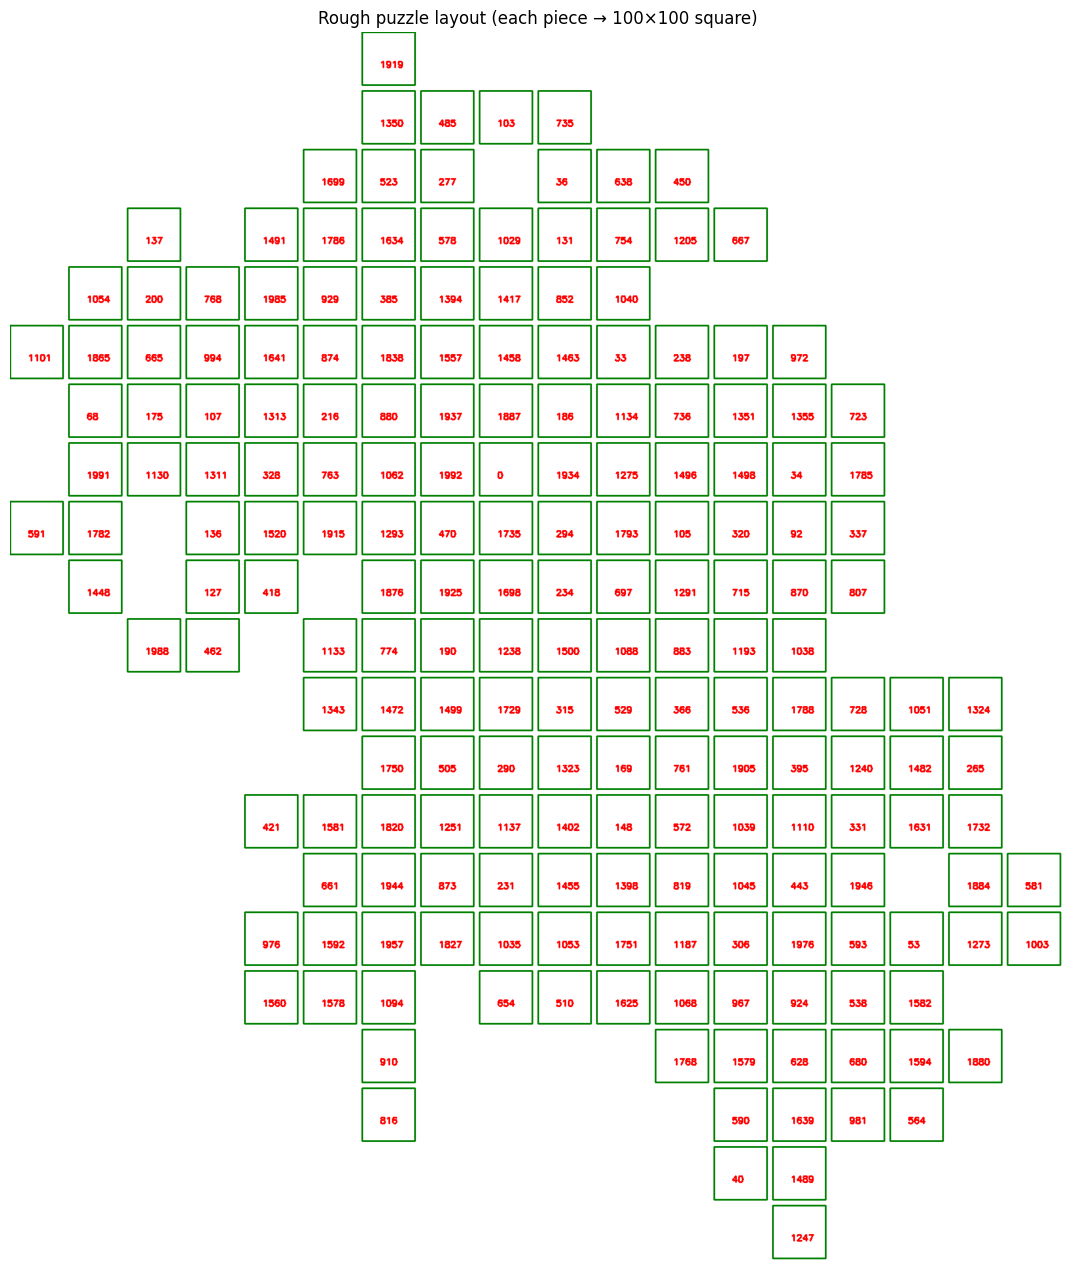

In [ ]:
# 2.8.1 Find min/max grid coords
xs = [coords[0] for coords in assembly.values()]
ys = [coords[1] for coords in assembly.values()]
min_x, max_x = min(xs), max(xs)
min_y, max_y = min(ys), max(ys)

# 2.8.2 Create a blank canvas (for visualization only)
grid_h = max_y - min_y + 1
grid_w = max_x - min_x + 1
canvas = np.ones((grid_h * 100, grid_w * 100, 3), dtype=np.uint8) * 255  # white canvas

# 2.8.3 Draw each placed piece as a rectangle + ID
for piece_idx, (x, y, rot) in assembly.items():
    # Remap puzzle coordinates to canvas coords (flip y for plotting)
    cx = (x - min_x) * 100
    cy = (max_y - y) * 100  # so that y increases upward on canvas

    # Draw a small square at the center
    cv2.putText(canvas, str(piece_idx), (cx + 30, cy + 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Optional: draw the bounding box of each piece (fixed size 100×100 for illustration)
    cv2.rectangle(canvas, (cx, cy), (cx + 90, cy + 90), (0, 128, 0), 2)

plt.figure(figsize=(16, 16))
plt.imshow(canvas[:, :, ::-1])  # BGR → RGB
plt.title("Rough puzzle layout (each piece → 100×100 square)")
plt.axis("off")


In [ ]:
# prompt: Display how many total pieces there are

print(f"There are {len(all_pieces)} pieces.")

There are 2000 pieces.


Visualizing specific pieces:


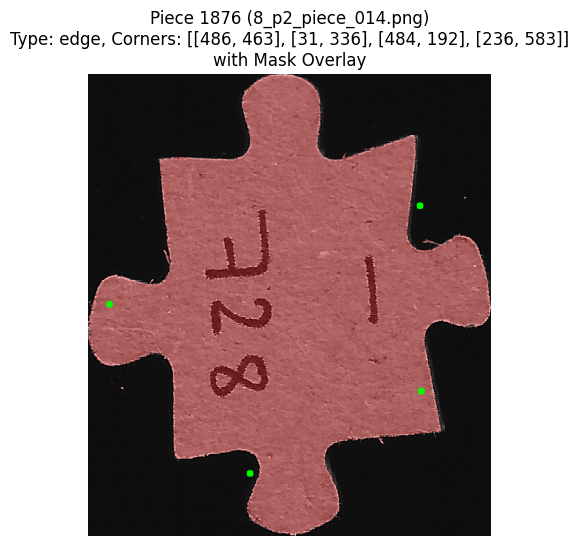

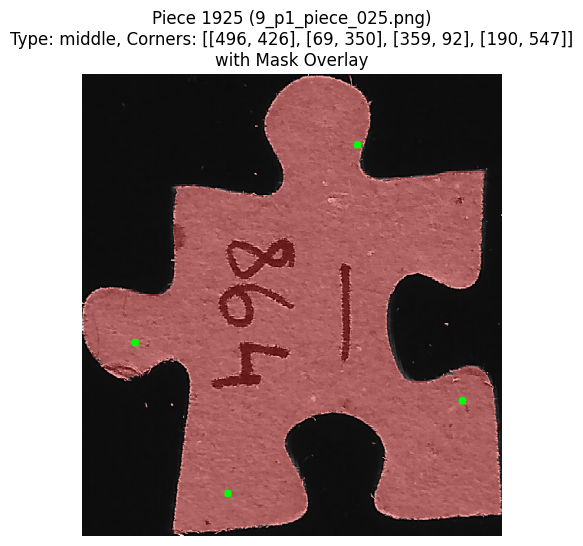

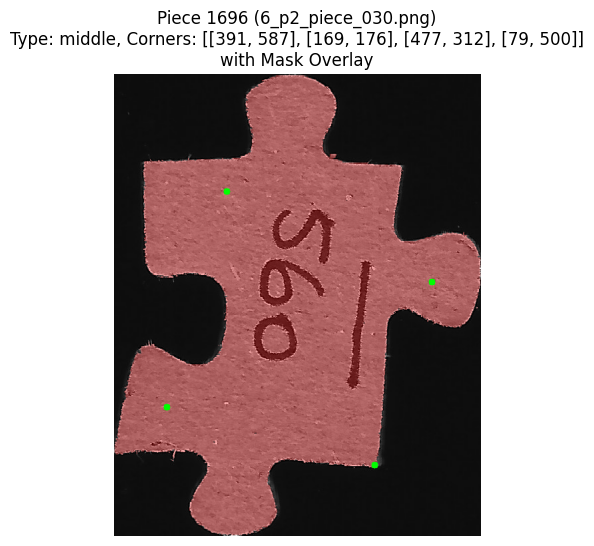

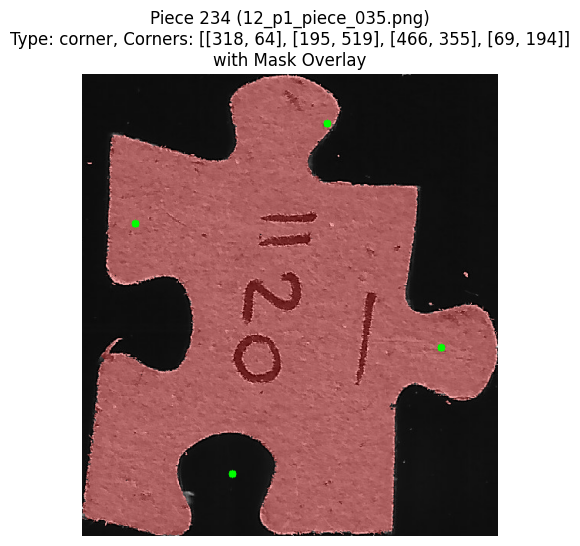

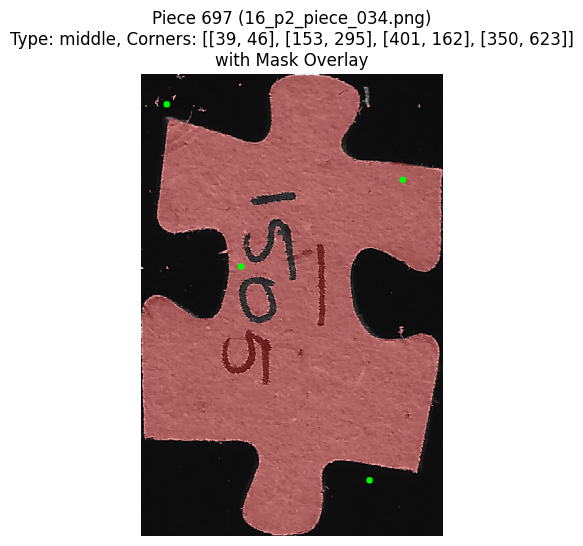

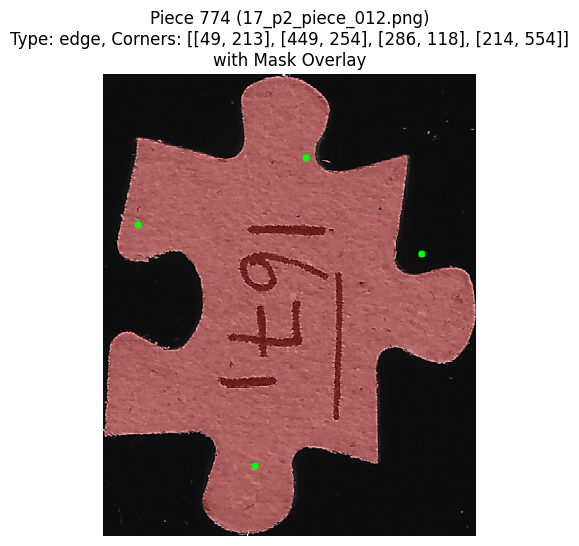

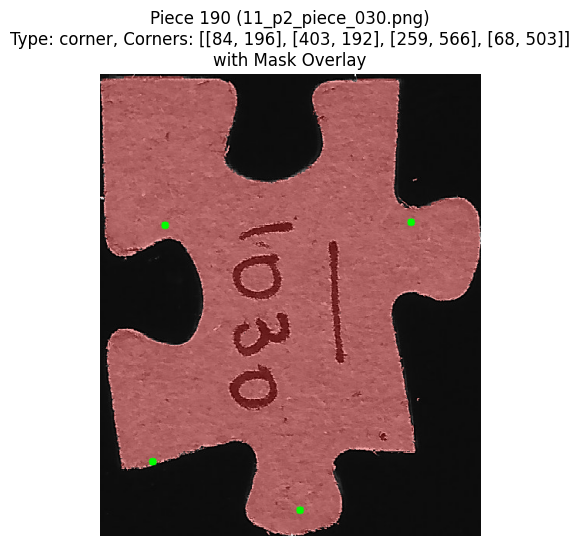

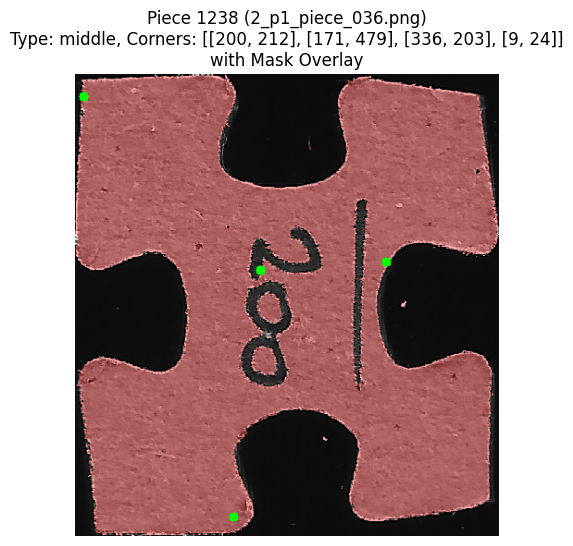

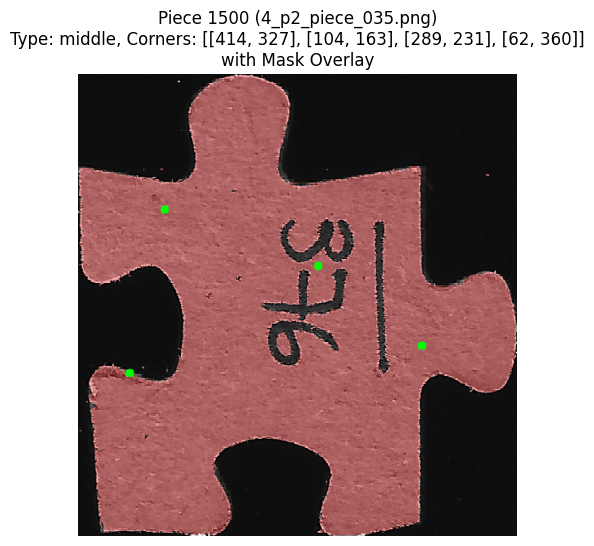

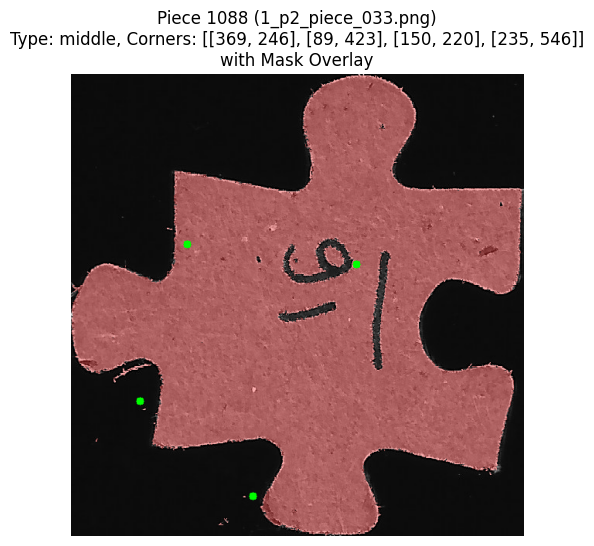

In [ ]:
# prompt: Can you show pieces 1876, 1925, 1696, 234, 697, 774, 190, 1238, 1500, and 1088

pieces_to_show = [1876, 1925, 1696, 234, 697, 774, 190, 1238, 1500, 1088]

print("Visualizing specific pieces:")

for piece_idx in pieces_to_show:
    if piece_idx < 0 or piece_idx >= len(all_pieces):
        print(f"Piece index {piece_idx} is out of bounds. Skipping.")
        continue

    fname = all_pieces[piece_idx]
    img_path = os.path.join(image_folder, fname)
    orig = cv2.imread(img_path)

    if orig is None:
        print(f"Could not read image for piece {piece_idx} ({fname}). Skipping.")
        continue

    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Optional: Load and overlay the final mask if you want to see the segmented area
    mask_path = os.path.join(mask_folder, f"{os.path.splitext(fname)[0]}_mask.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is not None:
        mask_binary = (mask // 255).astype(np.uint8)
        # Create a blended image with red overlay on the mask area
        red_layer = np.full(orig_rgb.shape, [255, 0, 0], dtype=np.uint8)
        mask_3chan = np.stack([mask_binary]*3, axis=-1)
        # Blend: (1-alpha)*original + alpha*red where mask is 1
        alpha = 0.3
        blended_viz = orig_rgb.copy()
        # Ensure the mask is treated as a boolean mask for indexing
        blended_viz[mask_binary == 1] = (1 - alpha) * blended_viz[mask_binary == 1].astype(np.float32) + alpha * np.array([255, 0, 0], dtype=np.float32)
        blended_viz = blended_viz.astype(np.uint8)
        display_img = blended_viz
        title_suffix = "with Mask Overlay"
    else:
        display_img = orig_rgb
        title_suffix = "Original"
        print(f"Warning: Mask not found for piece {piece_idx} ({fname}). Displaying original image.")


    # Optional: Display the detected corners if available for this piece
    corner_info = "Corners: Not Processed"
    if piece_idx in piece_corner_map:
        corners4 = piece_corner_map[piece_idx]
        # Draw corners on a copy for display
        display_img_with_corners = display_img.copy()
        for pt in corners4:
            cv2.circle(display_img_with_corners, tuple(pt), 5, (0, 255, 0), -1) # Green circles
        display_img = display_img_with_corners
        corner_info = f"Corners: {corners4.tolist()}"


    # Optional: Display the classified piece type
    type_info = "Type: Unknown"
    if piece_idx in piece_type_map:
        type_info = f"Type: {piece_type_map[piece_idx]}"


    plt.figure(figsize=(6, 6))
    plt.imshow(display_img)
    plt.title(f"Piece {piece_idx} ({fname})\n{type_info}, {corner_info}\n{title_suffix}")
    plt.axis('off')
    plt.show()
